In [3]:
import pandas as pd
import json
import requests
from pprint import pprint
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
%matplotlib inline

***

# FSP maps

**Type_id, colors, and number of points**

All types

```sql
SELECT iso, sector, type, type_id, color, count(*) as number_of_points
FROM fsp_maps
GROUP BY iso, sector, type, type_id, color
ORDER BY iso, sector, type, type_id, color
```

Selected types

```sql
SELECT iso, sector, type, type_id, color, count(*) as number_of_points
FROM fsp_maps
WHERE iso = 'KEN' and sector = 'Agriculture' and type in ('Agro-Dealers', 'Market Locations')
GROUP BY iso, sector, type, type_id, color
ORDER BY iso, sector, type, type_id, color
```

***

# FSP layers

## Points

**Query**

```sql
SELECT the_geom, the_geom_webmercator, iso, sector, type FROM fsp_maps
WHERE type_id in (40,51,58,62,67)
```

**CSS**

```css
#layer {
  marker-width: 7;
  marker-fill: #EE4D5A;
  marker-fill-opacity: 0.9;
  marker-line-color: #FFFFFF;
  marker-line-width: 1;
  marker-line-opacity: 1;
  marker-placement: point;
  marker-type: ellipse;
  marker-allow-overlap: true;
}
```

## Heat map

**Query**

```sql
SELECT the_geom,the_geom_webmercator FROM fsp_maps WHERE type_id = 40
```

**CSS**

```css
#layer {
  marker-width:10; 
  image-filters:colorize-alpha(blue, cyan, green, yellow , orange, red);
  marker-opacity:0.1;
  marker-multi-policy: largest; 
  marker-line-opacity:0;
  marker-allow-overlap: true;
  marker-type: ellipse; 
  marker-placement: point;
}
```

**choropleth**

## Voronoid

**Query**

```sql 
SELECT the_geom , the_geom_webmercator, area_km2 
FROM fsp_voronoid
WHERE type_id = 40
```

**CSS**

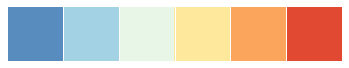

In [113]:
sns.palplot(sns.color_palette("RdYlBu_r", 6))

In [114]:
sns.color_palette("RdYlBu_r", 6).as_hex()

['#588cc0', '#a3d3e6', '#e9f6e8', '#fee99d', '#fca55d', '#e34933']

In [ ]:
(#4574b3, #74add1, #aad8e9, #e0f3f8, #fffebe, #fee090, #fdad60, #f46d43, #d62f27)

```css
#layer {
  polygon-fill: ramp([area_km2], (#f6d2a9, #f3aa84, #ea8171, #d55d6a, #b13f64), jenks);
  polygon-opacity: 0.7; 
  line-width: 1;
  line-color: ramp([area_km2], (#f6d2a9, #f3aa84, #ea8171, #d55d6a, #b13f64), jenks);
  line-opacity: 1;
}
```

**choropleth**

```sql
SELECT round(unnest(CDB_JenksBins(array_agg(area_km2::numeric),5)),1) as bucket 
FROM fsp_voronoid
WHERE type_id = 40
```

*** 

# Contextual layers

**Layers' name**

```sql
SELECT layer FROM layer_spec
```

## From Carto 

**Query and CSS**

```sql
SELECT queries, css FROM layer_spec WHERE layer = 'AidData'
```

## From RW API

**Layer id**

```sql
SELECT layer_id FROM layer_spec WHERE layer = 'Accessibility to Cities'
```

***

# FSP maps analysis

## Country information
**Total, urban, and rural population, their percentages, and population within 5 km of all access points**

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b 
            WHERE b.iso_a3 = 'UGA'),
     u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u
             JOIN world_borders_hd as b
               ON ST_Intersects(b.the_geom, u.the_geom)
            WHERE b.iso_a3 = 'UGA')
            
SELECT tot.pop as total_population, urb.pop as urban_population, 
  round(((urb.pop/tot.pop)*100)::numeric, 1) as urban_population_percentage, (tot.pop - urb.pop) as 
  rural_population, round((((tot.pop - urb.pop)/tot.pop)*100)::numeric,1) as   
  rural_population_percentage, round(pop_km.tot_pop_km::numeric) as population_5km,
  round(((round(pop_km.tot_pop_km::numeric)/tot.pop)*100)::numeric, 1) as population_5km_percentage,
  2015 as year
FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop
        FROM population_count_2015, b 
       WHERE ST_Intersects(the_raster_webmercator, b.the_geom)
      ) as tot,
     (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop
        FROM population_count_2015, u 
       WHERE ST_Intersects(the_raster_webmercator, u.the_geom)
      ) as urb,
     (SELECT total_population as tot_pop_km
        FROM population_within_5km 
       WHERE iso = 'UGA'
      ) as pop_km
```

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b 
            WHERE b.iso_a3 = 'UGA'),
     p as (SELECT the_geom FROM population_within_5km as p
            WHERE iso = 'UGA'),
     u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u
             JOIN world_borders_hd as b
               ON ST_Intersects(b.the_geom, u.the_geom)
            WHERE b.iso_a3 = 'UGA')
            
SELECT tot.pop as total_population, urb.pop as urban_population, 
  round(((urb.pop/tot.pop)*100)::numeric, 1) as urban_population_percentage, (tot.pop - urb.pop) as 
  rural_population, round((((tot.pop - urb.pop)/tot.pop)*100)::numeric,1) as   
  rural_population_percentage, pop_km.pop as population_5km,
  round(((pop_km.pop/tot.pop)*100)::numeric, 1) as population_5km_percentage,
  2015 as year
FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop
        FROM population_count_2015, b 
       WHERE ST_Intersects(the_raster_webmercator, b.the_geom)
      ) as tot,
     (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop
        FROM population_count_2015, u 
       WHERE ST_Intersects(the_raster_webmercator, u.the_geom)
      ) as urb,
     (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, p.the_geom),1,True)).sum) as pop
        FROM population_count_2015, p 
       WHERE ST_Intersects(the_raster_webmercator, p.the_geom)
      ) as pop_km
```

*widget_config*

In [3]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'account'
            },
            {
                'required': True,
                'key': 'iso'
            }
        ],
        'sql_query': 'https://{{account}}.carto.com/api/v2/sql?q=WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}), p as (SELECT the_geom FROM population_within_5km as p WHERE iso = {{iso}}), u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u JOIN world_borders_hd as b ON ST_Intersects(b.the_geom, u.the_geom) WHERE b.iso_a3 = {{iso}}) SELECT tot.pop as total_population, urb.pop as urban_population, round(((urb.pop/tot.pop)*100)::numeric, 1) as urban_population_percentage, (tot.pop - urb.pop) as rural_population, round((((tot.pop - urb.pop)/tot.pop)*100)::numeric,1) as rural_population_percentage, pop_km.pop as population_5km, round(((pop_km.pop/tot.pop)*100)::numeric, 1) as population_5km_percentage, 2015 as year FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop FROM population_count_2015, b WHERE ST_Intersects(the_raster_webmercator, b.the_geom)) as tot, (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop FROM population_count_2015, u WHERE ST_Intersects(the_raster_webmercator, u.the_geom)) as urb, (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, p.the_geom),1,True)).sum) as pop FROM population_count_2015, p WHERE ST_Intersects(the_raster_webmercator, p.the_geom)) as pop_km',
      
        'type': 'text'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "account"}, {"required": true, "key": "iso"}], "sql_query": "https://{{account}}.carto.com/api/v2/sql?q=WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}), p as (SELECT the_geom FROM population_within_5km as p WHERE iso = {{iso}}), u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u JOIN world_borders_hd as b ON ST_Intersects(b.the_geom, u.the_geom) WHERE b.iso_a3 = {{iso}}) SELECT tot.pop as total_population, urb.pop as urban_population, round(((urb.pop/tot.pop)*100)::numeric, 1) as urban_population_percentage, (tot.pop - urb.pop) as rural_population, round((((tot.pop - urb.pop)/tot.pop)*100)::numeric,1) as rural_population_percentage, pop_km.pop as population_5km, round(((pop_km.pop/tot.pop)*100)::numeric, 1) as population_5km_percentage, 2015 as year FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop FROM p

## Nearby Polygon
**We use this [API](https://openrouteservice.org/documentation/#/reference/isochrones/isochrones/isochrones-service) to get the geometries**

Example url:
```html
https://api.openrouteservice.org/isochrones?api_key=your-api-key&locations=8.34234%2C48.23424&profile=driving-car&range_type=time&range=60&interval=&units=m&location_type=start&attributes=&options=&intersections=&id=
```

In [31]:
api_key = '5b3ce3597851110001cf6248ce35abcdfc0547a283c2b4ab7e581dd8'
lng = '36.815185546875'
lat = '-1.282546686897245'
profile = 'foot-walking'
range = 2000 #Maximum range value of the analysis in seconds. 

url = f"https://api.openrouteservice.org/isochrones?api_key={api_key}&locations={lng}%2C{lat}&profile={profile}&range_type=time&range={range}"

r = requests.get(f"{url}")

In [32]:
r.json()

{'bbox': [36.793497, -1.305852, 36.838232, 0],
 'features': [{'geometry': {'coordinates': [[[36.793497, -1.276439],
      [36.795092, -1.28584],
      [36.795113, -1.289178],
      [36.796803, -1.295043],
      [36.797672, -1.296449],
      [36.800558, -1.299214],
      [36.801495, -1.29994],
      [36.811105, -1.303825],
      [36.812905, -1.303719],
      [36.824329, -1.305852],
      [36.827847, -1.30312],
      [36.82811, -1.302775],
      [36.829646, -1.29959],
      [36.834238, -1.290449],
      [36.836323, -1.289074],
      [36.837129, -1.287775],
      [36.838203, -1.285111],
      [36.838232, -1.284935],
      [36.837288, -1.277239],
      [36.835418, -1.268669],
      [36.83278, -1.265343],
      [36.832401, -1.265428],
      [36.82608, -1.265214],
      [36.818695, -1.258269],
      [36.818625, -1.258239],
      [36.818611, -1.258233],
      [36.817966, -1.25796],
      [36.811114, -1.259599],
      [36.799968, -1.261126],
      [36.799954, -1.26113],
      [36.795923, -1.26

Point

In [33]:
r.json().get('features')[0].get('properties').get('center')

[36.815186, -1.282547]

Polygon

In [34]:
json.dumps(r.json().get('features')[0].get('geometry'), separators=(',',':'))

'{"type":"Polygon","coordinates":[[[36.793497,-1.276439],[36.795092,-1.28584],[36.795113,-1.289178],[36.796803,-1.295043],[36.797672,-1.296449],[36.800558,-1.299214],[36.801495,-1.29994],[36.811105,-1.303825],[36.812905,-1.303719],[36.824329,-1.305852],[36.827847,-1.30312],[36.82811,-1.302775],[36.829646,-1.29959],[36.834238,-1.290449],[36.836323,-1.289074],[36.837129,-1.287775],[36.838203,-1.285111],[36.838232,-1.284935],[36.837288,-1.277239],[36.835418,-1.268669],[36.83278,-1.265343],[36.832401,-1.265428],[36.82608,-1.265214],[36.818695,-1.258269],[36.818625,-1.258239],[36.818611,-1.258233],[36.817966,-1.25796],[36.811114,-1.259599],[36.799968,-1.261126],[36.799954,-1.26113],[36.795923,-1.269467],[36.795084,-1.271342],[36.79378,-1.27427],[36.793497,-1.276439]]]}'

## Information
**Total selected access points and population (numeric)**

Polygon 

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('
{"type":"Polygon","coordinates":[[[36.1834716796875,-1.7465556193132534],[37.5238037109375,-1.7465556193132534],[37.5238037109375,-0.8459165322899671],[36.1834716796875,-0.8459165322899671],[36.1834716796875,-1.7465556193132534]]]}'),4326) as the_geom),
     u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u, b
           WHERE ST_Intersects(u.the_geom, b.the_geom))

SELECT points.count as access_points, tot.pop as total_population, COALESCE(urb.pop, tot.pop) as urban_population, 
  round(((COALESCE(urb.pop, tot.pop)/tot.pop)*100)::numeric, 1) as urban_population_percentage, (tot.pop - COALESCE(urb.pop, tot.pop)) as 
  rural_population, round((((tot.pop - COALESCE(urb.pop, tot.pop))/tot.pop)*100)::numeric,1) as   
  rural_population_percentage
FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop
        FROM population_count_2015, b 
       WHERE ST_Intersects(the_raster_webmercator, b.the_geom)
      ) as tot,
     (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop
        FROM population_count_2015, u 
       WHERE ST_Intersects(the_raster_webmercator, u.the_geom)
      ) as urb,
     (SELECT count(*) FROM
        (SELECT the_geom, the_geom_webmercator FROM fsp_maps
         UNION ALL
         SELECT the_geom, the_geom_webmercator FROM fsp_maps_users_staging
        ) as m, b  
       WHERE ST_Intersects(m.the_geom, b.the_geom) 
     ) as points
```

*widget_config* 

In [4]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'geojson'
            },
            {
                'required': True,
                'key': 'tableName1'
            },
            {
                'required': True,
                'key': 'tableName2'
            }
        ],
        'url': 'https://i2i-admin.carto.com/api/v2/sql',
        'sql_query_param': 'q',
        'sql_query': 'WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom), u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u, b WHERE ST_Intersects(u.the_geom, b.the_geom)) SELECT points.count as access_points, tot.pop as total_population, COALESCE(urb.pop, tot.pop) as urban_population, round(((COALESCE(urb.pop, tot.pop)/tot.pop)*100)::numeric, 1) as urban_population_percentage, (tot.pop - COALESCE(urb.pop, tot.pop)) as rural_population, round((((tot.pop - COALESCE(urb.pop, tot.pop))/tot.pop)*100)::numeric,1) as rural_population_percentage FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop FROM population_count_2015, b WHERE ST_Intersects(the_raster_webmercator, b.the_geom)) as tot, (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop FROM population_count_2015, u WHERE ST_Intersects(the_raster_webmercator, u.the_geom)) as urb, (SELECT count(*) FROM (SELECT the_geom, the_geom_webmercator FROM {{tableName1}} UNION ALL SELECT the_geom, the_geom_webmercator FROM {{tableName2}} ) as m, b WHERE ST_Intersects(m.the_geom, b.the_geom) ) as points',
        
        'type': 'summary'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}, {"required": true, "key": "tableName1"}, {"required": true, "key": "tableName2"}], "url": "https://i2i-admin.carto.com/api/v2/sql", "sql_query_param": "q", "sql_query": "WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom), u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u, b WHERE ST_Intersects(u.the_geom, b.the_geom)) SELECT points.count as access_points, tot.pop as total_population, COALESCE(urb.pop, tot.pop) as urban_population, round(((COALESCE(urb.pop, tot.pop)/tot.pop)*100)::numeric, 1) as urban_population_percentage, (tot.pop - COALESCE(urb.pop, tot.pop)) as rural_population, round((((tot.pop - COALESCE(urb.pop, tot.pop))/tot.pop)*100)::numeric,1) as rural_population_percentage FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop FROM population_count_2015, b WHERE ST_Intersects(the_raster_we

Country

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b 
            WHERE b.iso_a3 = 'UGA'),
     u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u
             JOIN world_borders_hd as b
               ON ST_Intersects(b.the_geom, u.the_geom)
            WHERE b.iso_a3 = 'UGA')

SELECT points.count as access_points, tot.pop as total_population, urb.pop as urban_population, 
  round(((urb.pop/tot.pop)*100)::numeric, 1) as urban_population_percentage, (tot.pop - urb.pop) as 
  rural_population, round((((tot.pop - urb.pop)/tot.pop)*100)::numeric,1) as   
  rural_population_percentage
FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop
        FROM population_count_2015, b 
       WHERE ST_Intersects(the_raster_webmercator, b.the_geom)
      ) as tot,
     (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop
        FROM population_count_2015, u 
       WHERE ST_Intersects(the_raster_webmercator, u.the_geom)
      ) as urb,
    (SELECT count(*) FROM
        (SELECT type FROM fsp_maps
         UNION ALL
         SELECT type FROM fsp_maps_users_staging
        ) as fsp_all 
     ) as points
```

*widget_config* 

In [5]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'iso'
            },
            {
                'required': True,
                'key': 'tableName1'
            },
            {
                'required': True,
                'key': 'tableName2'
            }
        ],
        'url': 'https://i2i-admin.carto.com/api/v2/sql',
        'sql_query_param': 'q',
        'sql_query': 'WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}), u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u JOIN world_borders_hd as b ON ST_Intersects(b.the_geom, u.the_geom) WHERE b.iso_a3 = {{iso}}) SELECT points.count as access_points, tot.pop as total_population, urb.pop as urban_population, round(((urb.pop/tot.pop)*100)::numeric, 1) as urban_population_percentage, (tot.pop - urb.pop) as rural_population, round((((tot.pop - urb.pop)/tot.pop)*100)::numeric,1) as rural_population_percentage FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop FROM population_count_2015, b WHERE ST_Intersects(the_raster_webmercator, b.the_geom)) as tot, (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop FROM population_count_2015, u WHERE ST_Intersects(the_raster_webmercator, u.the_geom)) as urb, (SELECT count(*) FROM (SELECT type FROM {{tableName1}} UNION ALL SELECT type FROM {{tableName2}}) as fsp_all ) as points',
      
        'type': 'summary'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "iso"}, {"required": true, "key": "tableName1"}, {"required": true, "key": "tableName2"}], "url": "https://i2i-admin.carto.com/api/v2/sql", "sql_query_param": "q", "sql_query": "WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}), u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u JOIN world_borders_hd as b ON ST_Intersects(b.the_geom, u.the_geom) WHERE b.iso_a3 = {{iso}}) SELECT points.count as access_points, tot.pop as total_population, urb.pop as urban_population, round(((urb.pop/tot.pop)*100)::numeric, 1) as urban_population_percentage, (tot.pop - urb.pop) as rural_population, round((((tot.pop - urb.pop)/tot.pop)*100)::numeric,1) as rural_population_percentage FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop FROM population_count_2015, b WHERE ST_Intersects(the_raster_webmercator, b.the_geom)) as tot, (S

## Charts

**Number of services**

Polygon

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('{"type":"Polygon","coordinates":[[[35.7275390625,-1.8014609294680355],[38.60595703125,-1.8014609294680355],[38.60595703125,-0.08789059053082422],[35.7275390625,-0.08789059053082422],[35.7275390625,-1.8014609294680355]]]}'),4326) as the_geom)

SELECT count(*) as value, m.type as label, 'Number of services' as unit 
FROM (SELECT type, the_geom, type_id, iso, sector FROM fsp_maps
      UNION ALL
      SELECT type, the_geom, type_id, iso, sector FROM fsp_maps_users_staging
      ) as m, b 
       WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in (40,51,58,62,67)
    GROUP BY m.iso, m.sector, m.type
```

*widget_config* 

In [8]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'geojson'
            },
            {
                'required': True,
                'key': 'type_ids'
            },
            {
                'required': True,
                'key': 'tableName1'
            },    
            {
                'required': True,
                'key': 'tableName2'
            }    
        ],
        'url': 'https://i2i-admin.carto.com/api/v2/sql',
        'sql_query_param': 'q',
        'sql_query': 'WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom) SELECT count(*) as value, m.type as label, \'Number of services\' as unit FROM (SELECT type, the_geom, type_id, iso, sector FROM {{tableName1}} UNION ALL SELECT type, the_geom, type_id, iso, sector FROM {{tableName2}}) as m, b WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in {{type_ids}} GROUP BY m.iso, m.sector, m.type',
      
        'type': 'grouped-bar'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}, {"required": true, "key": "type_ids"}, {"required": true, "key": "tableName1"}, {"required": true, "key": "tableName2"}], "url": "https://i2i-admin.carto.com/api/v2/sql", "sql_query_param": "q", "sql_query": "WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom) SELECT count(*) as value, m.type as label, \'Number of services\' as unit FROM (SELECT type, the_geom, type_id, iso, sector FROM {{tableName1}} UNION ALL SELECT type, the_geom, type_id, iso, sector FROM {{tableName2}}) as m, b WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in {{type_ids}} GROUP BY m.iso, m.sector, m.type", "type": "grouped-bar"}}'

Country

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b 
            WHERE b.iso_a3 = 'UGA')
            
SELECT count(*) as value, m.type as label, 'Number of services' as unit
FROM (SELECT type, the_geom, type_id, iso, sector FROM fsp_maps
      UNION ALL
      SELECT type, the_geom, type_id, iso, sector FROM fsp_maps_users_staging
      ) as m, b 
WHERE m.type_id in (40,51,58,62,67)
GROUP BY m.iso, m.sector, m.type
```

*widget_config* 

In [9]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'type_ids'
            },
            {
                'required': True,
                'key': 'iso'
            },
            {
                'required': True,
                'key': 'tableName1'
            },    
            {
                'required': True,
                'key': 'tableName2'
            } 
        ],
        'url': 'https://i2i-admin.carto.com/api/v2/sql',
        'sql_query_param': 'q',
        'sql_query': 'WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}) SELECT count(*) as value, m.type as label, \'Number of services\' as unit FROM (SELECT type, the_geom, type_id, iso, sector FROM {{tableName1}} UNION ALL SELECT type, the_geom, type_id, iso, sector FROM {{tableName2}}) as m, b WHERE m.type_id in {{type_ids}} GROUP BY m.iso, m.sector, m.type',
      
        'type': 'grouped-bar'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "type_ids"}, {"required": true, "key": "iso"}, {"required": true, "key": "tableName1"}, {"required": true, "key": "tableName2"}], "url": "https://i2i-admin.carto.com/api/v2/sql", "sql_query_param": "q", "sql_query": "WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}) SELECT count(*) as value, m.type as label, \'Number of services\' as unit FROM (SELECT type, the_geom, type_id, iso, sector FROM {{tableName1}} UNION ALL SELECT type, the_geom, type_id, iso, sector FROM {{tableName2}}) as m, b WHERE m.type_id in {{type_ids}} GROUP BY m.iso, m.sector, m.type", "type": "grouped-bar"}}'

**Access points %**

Polygon

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('{"type":"Polygon","coordinates":[[[35.7275390625,-1.8014609294680355],[38.60595703125,-1.8014609294680355],[38.60595703125,-0.08789059053082422],[35.7275390625,-0.08789059053082422],[35.7275390625,-1.8014609294680355]]]}'),4326) as the_geom)

SELECT round((points.count*1./tot.count*1.)*100, 1) as value, points.type as label, '%' as unit
FROM (SELECT count(*), m.iso, m.sector, m.type
        FROM fsp_maps as m, b  
       WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in (40,51,58,62,67)
    GROUP BY m.iso, m.sector, m.type
     ) as points,
    (SELECT count(*)
     FROM (SELECT type, the_geom, type_id, iso, sector FROM fsp_maps
           UNION ALL
           SELECT type, the_geom, type_id, iso, sector FROM fsp_maps_users_staging
           ) as m, b 
       WHERE ST_Intersects(b.the_geom, m.the_geom) and type_id in (40,51,58,62,67)
     ) as tot
```

*widget_config*

In [11]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'geojson'
            },
            {
                'required': True,
                'key': 'type_ids'
            },
            {
                'required': True,
                'key': 'tableName1'
            },
            {
                'required': True,
                'key': 'tableName2'
            }  
        ],
        'url': 'https://i2i-admin.carto.com/api/v2/sql',
        'sql_query_param': 'q',
        'sql_query': 'WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom) SELECT round((points.count*1./tot.count*1.)*100, 1) as value, points.type as label, \'%\' as unit FROM (SELECT count(*), m.iso, m.sector, m.type FROM fsp_maps as m, b WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in {{type_ids}} GROUP BY m.iso, m.sector, m.type) as points, (SELECT count(*) FROM (SELECT type, the_geom, type_id, iso, sector FROM {{tableName1}} UNION ALL SELECT type, the_geom, type_id, iso, sector FROM {{tableName2}}) as m, b WHERE ST_Intersects(b.the_geom, m.the_geom) and type_id in {{type_ids}}) as tot',
      
        'type': 'pie'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}, {"required": true, "key": "type_ids"}, {"required": true, "key": "tableName1"}, {"required": true, "key": "tableName2"}], "url": "https://i2i-admin.carto.com/api/v2/sql", "sql_query_param": "q", "sql_query": "WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom) SELECT round((points.count*1./tot.count*1.)*100, 1) as value, points.type as label, \'%\' as unit FROM (SELECT count(*), m.iso, m.sector, m.type FROM fsp_maps as m, b WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in {{type_ids}} GROUP BY m.iso, m.sector, m.type) as points, (SELECT count(*) FROM (SELECT type, the_geom, type_id, iso, sector FROM {{tableName1}} UNION ALL SELECT type, the_geom, type_id, iso, sector FROM {{tableName2}}) as m, b WHERE ST_Intersects(b.the_geom, m.the_geom) and type_id in {{type_ids}}) as tot", "type": "pie"}}'

Country

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b 
            WHERE b.iso_a3 = 'UGA')
            
SELECT round((points.count*1./tot.count)*100, 1) as value, points.type as label, '%' as unit
FROM (SELECT count(*), m.iso, m.sector, m.type
      FROM (SELECT type, the_geom, type_id, iso, sector FROM fsp_maps
            UNION ALL
            SELECT type, the_geom, type_id, iso, sector FROM fsp_maps_users_staging
            ) as m, b 
       WHERE m.type_id in (40,51,58,62,67)
    GROUP BY m.iso, m.sector, m.type
     ) as points,
    (SELECT count(*)
     FROM (SELECT type_id FROM fsp_maps
           UNION ALL
           SELECT type_id FROM fsp_maps_users_staging
           ) as m  
       WHERE type_id in (40,51,58,62,67)
     ) as tot
```

*widget_config*

In [12]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'type_ids'
            },
            {
                'required': True,
                'key': 'iso'
            },
            {
                'required': True,
                'key': 'tableName1'
            },
            {
                'required': True,
                'key': 'tableName2'
            }  
        ],
        'url': 'https://i2i-admin.carto.com/api/v2/sql',
        'sql_query_param': 'q',
        'sql_query': 'WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}) SELECT round((points.count*1./tot.count)*100, 1) as value, points.type as label, \'%\' as unit FROM (SELECT count(*), m.iso, m.sector, m.type FROM (SELECT type, the_geom, type_id, iso, sector FROM {{tableName1}} UNION ALL SELECT type, the_geom, type_id, iso, sector FROM {{tableName2}}) as m, b WHERE m.type_id in {{type_ids}} GROUP BY m.iso, m.sector, m.type) as points, (SELECT count(*) FROM (SELECT type_id FROM {{tableName1}} UNION ALL SELECT type_id FROM {{tableName2}}) as m WHERE type_id in {{type_ids}}) as tot',
      
        'type': 'pie'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "type_ids"}, {"required": true, "key": "iso"}, {"required": true, "key": "tableName1"}, {"required": true, "key": "tableName2"}], "url": "https://i2i-admin.carto.com/api/v2/sql", "sql_query_param": "q", "sql_query": "WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}) SELECT round((points.count*1./tot.count)*100, 1) as value, points.type as label, \'%\' as unit FROM (SELECT count(*), m.iso, m.sector, m.type FROM (SELECT type, the_geom, type_id, iso, sector FROM {{tableName1}} UNION ALL SELECT type, the_geom, type_id, iso, sector FROM {{tableName2}}) as m, b WHERE m.type_id in {{type_ids}} GROUP BY m.iso, m.sector, m.type) as points, (SELECT count(*) FROM (SELECT type_id FROM {{tableName1}} UNION ALL SELECT type_id FROM {{tableName2}}) as m WHERE type_id in {{type_ids}}) as tot", "type": "pie"}}'

**Distance to access points (min, mean, max)**

Polygon (Nearby)

```sql
WITH p as (SELECT ST_Transform(ST_GeomFromText('POINT(36.815186 -1.282547)',4326),26986) as the_geom), 
     b as (SELECT ST_setsrid(ST_Geomfromgeojson('
{"type":"Polygon","coordinates":[[[36.793497,-1.276439],[36.795092,-1.28584],[36.795113,-1.289178],[36.796803,-1.295043],[36.797672,-1.296449],[36.800558,-1.299214],[36.801495,-1.29994],[36.811105,-1.303825],[36.812905,-1.303719],[36.824329,-1.305852],[36.827847,-1.30312],[36.82811,-1.302775],[36.829646,-1.29959],[36.834238,-1.290449],[36.836323,-1.289074],[36.837129,-1.287775],[36.838203,-1.285111],[36.838232,-1.284935],[36.837288,-1.277239],[36.835418,-1.268669],[36.83278,-1.265343],[36.832401,-1.265428],[36.82608,-1.265214],[36.818695,-1.258269],[36.818625,-1.258239],[36.818611,-1.258233],[36.817966,-1.25796],[36.811114,-1.259599],[36.799968,-1.261126],[36.799954,-1.26113],[36.795923,-1.269467],[36.795084,-1.271342],[36.79378,-1.27427],[36.793497,-1.276439]]]}'),4326) as the_geom)

SELECT min(ST_Distance(p.the_geom, ST_Transform(m.the_geom,26986))/1000.) as value, avg(ST_Distance(p.the_geom, ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, max(ST_Distance(p.the_geom, ST_Transform(m.the_geom,26986))/1000.) as max_distance_km, m.type as label, 'km' as unit, 'Distance (km)' as title
FROM (SELECT type, the_geom, type_id, iso, sector FROM fsp_maps
      UNION ALL
      SELECT type, the_geom, type_id, iso, sector FROM fsp_maps_users_staging
      ) as m, b, p  
WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in (40,51,58,62,67)
GROUP BY m.iso, m.sector, m.type  
```

*widget_config*

In [13]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'lng'
            },
            {
                'required': True,
                'key': 'lat'
            },
            {
                'required': True,
                'key': 'geojson'
            },
            {
                'required': True,
                'key': 'type_ids'
            },
            {
                'required': True,
                'key': 'tableName1'
            },
            {
                'required': True,
                'key': 'tableName2'
            }              
        ],
        'url': 'https://i2i-admin.carto.com/api/v2/sql',
        'sql_query_param': 'q',
        'sql_query': 'WITH p as (SELECT ST_Transform(ST_GeomFromText(\'POINT({{lng}} {{lat}})\',4326),26986) as the_geom), b as (SELECT ST_setsrid(ST_Geomfromgeojson({{geojson}}),4326) as the_geom) SELECT min(ST_Distance(p.the_geom, ST_Transform(m.the_geom,26986))/1000.) as value, avg(ST_Distance(p.the_geom, ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, max(ST_Distance(p.the_geom, ST_Transform(m.the_geom,26986))/1000.) as max_distance_km, m.type as label, \'km\' as unit, \'Distance (km)\' as title FROM (SELECT type, the_geom, type_id, iso, sector FROM {{tableName1}} UNION ALL SELECT type, the_geom, type_id, iso, sector FROM {{tableName2}}) as m, b, p WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in {{type_ids}} GROUP BY m.iso, m.sector, m.type',
      
        'type': 'grouped-bar'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "lng"}, {"required": true, "key": "lat"}, {"required": true, "key": "geojson"}, {"required": true, "key": "type_ids"}, {"required": true, "key": "tableName1"}, {"required": true, "key": "tableName2"}], "url": "https://i2i-admin.carto.com/api/v2/sql", "sql_query_param": "q", "sql_query": "WITH p as (SELECT ST_Transform(ST_GeomFromText(\'POINT({{lng}} {{lat}})\',4326),26986) as the_geom), b as (SELECT ST_setsrid(ST_Geomfromgeojson({{geojson}}),4326) as the_geom) SELECT min(ST_Distance(p.the_geom, ST_Transform(m.the_geom,26986))/1000.) as value, avg(ST_Distance(p.the_geom, ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, max(ST_Distance(p.the_geom, ST_Transform(m.the_geom,26986))/1000.) as max_distance_km, m.type as label, \'km\' as unit, \'Distance (km)\' as title FROM (SELECT type, the_geom, type_id, iso, sector FROM {{tableName1}} UNION ALL SELECT type, the_geom, type_id, iso, sector FROM {{tableName2}}) as m, b,

Polygon (Area of interest)

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('{"type":"Polygon","coordinates":[[[36.78497314453124,-1.3045137436059018],[36.84883117675781,-1.3045137436059018],[36.84883117675781,-1.2646983143314325],[36.78497314453124,-1.2646983143314325],[36.78497314453124,-1.3045137436059018]]]}'),4326) as the_geom)

SELECT min(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as value, avg(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, max(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as max_distance_km, m.iso, m.sector, m.type as label, 'km' as unit, 'Distance (km)' as title 
FROM (SELECT the_geom, type_id, iso, sector, type FROM fsp_maps
      UNION ALL
      SELECT the_geom, type_id, iso, sector, type FROM fsp_maps_users_staging
      ) as m, b 
WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in (40,51,58,62,67)
GROUP BY m.iso, m.sector, m.type
```

*widget_config*

In [14]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'geojson'
            },
            {
                'required': True,
                'key': 'type_ids'
            },
            {
                'required': True,
                'key': 'tableName1'
            },
            {
                'required': True,
                'key': 'tableName2'
            }             
        ],
        'url': 'https://i2i-admin.carto.com/api/v2/sql',
        'sql_query_param': 'q',
        'sql_query': 'WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom) SELECT min(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as value, avg(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, max(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as max_distance_km, m.iso, m.sector, m.type as label, \'km\' as unit, \'Distance (km)\' as title FROM (SELECT the_geom, type_id, iso, sector, type FROM {{tableName1}} UNION ALL SELECT the_geom, type_id, iso, sector, type FROM {{tableName2}}) as m, b WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in {{type_ids}} GROUP BY m.iso, m.sector, m.type',
      
        'type': 'grouped-bar'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}, {"required": true, "key": "type_ids"}, {"required": true, "key": "tableName1"}, {"required": true, "key": "tableName2"}], "url": "https://i2i-admin.carto.com/api/v2/sql", "sql_query_param": "q", "sql_query": "WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom) SELECT min(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as value, avg(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, max(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as max_distance_km, m.iso, m.sector, m.type as label, \'km\' as unit, \'Distance (km)\' as title FROM (SELECT the_geom, type_id, iso, sector, type FROM {{tableName1}} UNION ALL SELECT the_geom, type_id, iso, sector, type FROM {{tableName2}}) as m, b WHERE ST_Intersects(b.the_geom, m.the_geom) a

Country

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b 
            WHERE b.iso_a3 = 'UGA')
            
SELECT min(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as value, avg(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, max(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as max_distance_km, m.iso, m.sector, m.type as label, 'km' as unit, 'Distance (km)' as title
FROM (SELECT the_geom, type_id, iso, sector, type FROM fsp_maps
      UNION ALL
      SELECT the_geom, type_id, iso, sector, type FROM fsp_maps_users_staging
      ) as m, b 
       WHERE m.type_id in (40)
    GROUP BY m.iso, m.sector, m.type
```

*widget_config*

In [15]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'type_ids'
            },
            {
                'required': True,
                'key': 'iso'
            },
            {
                'required': True,
                'key': 'tableName1'
            },
            {
                'required': True,
                'key': 'tableName2'
            }       
        ],
        'url': 'https://i2i-admin.carto.com/api/v2/sql',
        'sql_query_param': 'q',
        'sql_query': 'WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}) SELECT min(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as value, avg(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, max(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as max_distance_km, m.iso, m.sector, m.type as label, \'km\' as unit, \'Distance (km)\' as title FROM (SELECT the_geom, type_id, iso, sector, type FROM {{tableName1}} UNION ALL SELECT the_geom, type_id, iso, sector, type FROM {{tableName2}}) as m, b WHERE m.type_id in {{type_ids}} GROUP BY m.iso, m.sector, m.type',
      
        'type': 'grouped-bar'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "type_ids"}, {"required": true, "key": "iso"}, {"required": true, "key": "tableName1"}, {"required": true, "key": "tableName2"}], "url": "https://i2i-admin.carto.com/api/v2/sql", "sql_query_param": "q", "sql_query": "WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}) SELECT min(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as value, avg(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, max(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as max_distance_km, m.iso, m.sector, m.type as label, \'km\' as unit, \'Distance (km)\' as title FROM (SELECT the_geom, type_id, iso, sector, type FROM {{tableName1}} UNION ALL SELECT the_geom, type_id, iso, sector, type FROM {{tableName2}}) as m, b WHERE m.type_id in {{type_ids}} GROUP BY m.iso, m

**All together**

Polygon (Nearby)

```sql
WITH p as (SELECT ST_Transform(ST_GeomFromText('POINT(36.815186 -1.282547)',4326),26986) as the_geom), 
     b as (SELECT st_setsrid(st_geomfromgeojson('
{"type":"Polygon","coordinates":[[[36.793497,-1.276439],[36.795092,-1.28584],[36.795113,-1.289178],[36.796803,-1.295043],[36.797672,-1.296449],[36.800558,-1.299214],[36.801495,-1.29994],[36.811105,-1.303825],[36.812905,-1.303719],[36.824329,-1.305852],[36.827847,-1.30312],[36.82811,-1.302775],[36.829646,-1.29959],[36.834238,-1.290449],[36.836323,-1.289074],[36.837129,-1.287775],[36.838203,-1.285111],[36.838232,-1.284935],[36.837288,-1.277239],[36.835418,-1.268669],[36.83278,-1.265343],[36.832401,-1.265428],[36.82608,-1.265214],[36.818695,-1.258269],[36.818625,-1.258239],[36.818611,-1.258233],[36.817966,-1.25796],[36.811114,-1.259599],[36.799968,-1.261126],[36.799954,-1.26113],[36.795923,-1.269467],[36.795084,-1.271342],[36.79378,-1.27427],[36.793497,-1.276439]]]}'),4326) as the_geom)

SELECT points.count as access_points, round((points.count*1./tot.count*1.)*100, 1) as access_points_percentage, points.mean_distance_km, points.iso, points.sector, points.type 
FROM (SELECT count(*), min(ST_Distance(p.the_geom, ST_Transform(m.the_geom,26986))/1000.) as min_distance_km, avg(ST_Distance(p.the_geom, ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, m.iso, m.sector, m.type
        FROM fsp_maps as m, b, p  
       WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in (40,51,58,62,67)
    GROUP BY m.iso, m.sector, m.type
     ) as points,
    (SELECT count(*)
        FROM fsp_maps as m, b
       WHERE ST_Intersects(b.the_geom, m.the_geom) and type_id in (40,51,58,62,67)
     ) as tot
```

Polygon (Area of interest)

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('{"type":"Polygon","coordinates":[[[36.78497314453124,-1.3045137436059018],[36.84883117675781,-1.3045137436059018],[36.84883117675781,-1.2646983143314325],[36.78497314453124,-1.2646983143314325],[36.78497314453124,-1.3045137436059018]]]}'),4326) as the_geom)

SELECT points.count as access_points, round((points.count*1./tot.count*1.)*100, 1) as access_points_percentage, points.mean_distance_km, points.iso, points.sector, points.type 
FROM (SELECT count(*), avg(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, m.iso, m.sector, m.type
        FROM fsp_maps as m, b  
       WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in (40,51,58,62,67)
    GROUP BY m.iso, m.sector, m.type
     ) as points,
    (SELECT count(*)
        FROM fsp_maps as m, b
       WHERE ST_Intersects(b.the_geom, m.the_geom) and type_id in (40,51,58,62,67)
     ) as tot
```

Country

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b 
            WHERE b.iso_a3 = 'KEN')
            
SELECT points.count as access_points, round((points.count*1./tot.count)*100, 1) as access_points_percentage, points.mean_distance_km, points.iso, points.sector, points.type 
FROM (SELECT count(*), avg(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, m.iso, m.sector, m.type
        FROM fsp_maps as m, b  
       WHERE m.type_id in (40,51,58,62,67)
    GROUP BY m.iso, m.sector, m.type
     ) as points,
    (SELECT count(*)
        FROM fsp_maps 
       WHERE type_id in (40,51,58,62,67)
     ) as tot
```

**Example plots with python**

In [ ]:
iso = 'KEN'

query =("WITH b as (SELECT st_setsrid(st_geomfromgeojson('{\"type\":\"Polygon\",\"coordinates\":[[[36.78497314453124,-1.3045137436059018],[36.84883117675781,-1.3045137436059018],[36.84883117675781,-1.2646983143314325],[36.78497314453124,-1.2646983143314325],[36.78497314453124,-1.3045137436059018]]]}'),4326) as the_geom) "
"SELECT points.count as access_points, round((points.count*1./tot.count*1.)*100, 1) as access_points_percentage, points.mean_distance_km, points.iso, points.sector, points.type "
"FROM (SELECT count(*), avg(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, m.iso, m.sector, m.type "
"FROM fsp_maps as m, b "
"WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in (40,51,58,62,67) "
"GROUP BY m.iso, m.sector, m.type "
") as points, "
"(SELECT count(*) "
"FROM fsp_maps as m, b "
"WHERE ST_Intersects(b.the_geom, m.the_geom) and type_id in (40,51,58,62,67) "
") as tot "
)

account = 'ikerey'
urlCarto = f"https://{account}.carto.com/api/v2/sql"

sql = {"q": query}
r = requests.get(urlCarto, params=sql)

data = r.json().get('rows')
df = pd.DataFrame.from_dict(json_normalize(data))
df.head()

Acces Points %

In [ ]:
counts = df['access_points_percentage']
labels = df['type']
plt.figure(figsize=(5,5))
plt.pie(counts, autopct='%1.1f%%')
plt.legend(labels);

Number of services

In [ ]:
df.plot(x='type', y='access_points', kind='barh')

Mean distance to access points

In [ ]:
df.plot(x='type', y='mean_distance_km', kind='barh')

*** 

# Contextual layers analysis

## AidData 
**Total transaction value per year (chart)**

Polygon 

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('
{"type":"Polygon","coordinates":[[[30.618896484375,-0.5053645409602877],[31.651611328125004,-0.5053645409602877],[31.651611328125004,0.208739772610497],[30.618896484375,0.208739772610497],[30.618896484375,-0.5053645409602877]]]}'),4326) as the_geom)
            
  SELECT transaction_year as label, sum(transaction_value) as value, transaction_currency as unit
    FROM aiddata_transactions as a, b
   WHERE ST_Intersects(b.the_geom, a.the_geom)
GROUP BY transaction_year, transaction_currency
ORDER BY transaction_year, transaction_currency
```

*widget_config*

In [149]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'geojson'
            }           
        ],
        'url': 'https://i2i-admin.carto.com/api/v2/sql',
        'sql_query_param': 'q',
        'sql_query': 'WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom) SELECT transaction_year as label, sum(transaction_value) as value, transaction_currency as unit FROM aiddata_transactions as a, b WHERE ST_Intersects(b.the_geom, a.the_geom) GROUP BY transaction_year, transaction_currency ORDER BY transaction_year, transaction_currency',
      
        'type': 'bar'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "url": "https://i2i-admin.carto.com/api/v2/sql", "sql_query_param": "q", "sql_query": "WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom) SELECT transaction_year as label, sum(transaction_value) as value, transaction_currency as unit FROM aiddata_transactions as a, b WHERE ST_Intersects(b.the_geom, a.the_geom) GROUP BY transaction_year, transaction_currency ORDER BY transaction_year, transaction_currency", "type": "bar"}}'

Country

```sql
SELECT transaction_year as label, sum(transaction_value) as value, transaction_currency as unit
    FROM aiddata_transactions 
   WHERE iso_a3 = 'UGA'
GROUP BY transaction_year, transaction_currency
ORDER BY transaction_year, transaction_currency
```

*widget_config*

In [150]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'iso'
            }           
        ],
        'url': 'https://i2i-admin.carto.com/api/v2/sql',
        'sql_query_param': 'q',
        'sql_query': 'SELECT transaction_year as label, sum(transaction_value) as value, transaction_currency as unit FROM aiddata_transactions WHERE iso_a3 = {{iso}} GROUP BY transaction_year, transaction_currency ORDER BY transaction_year, transaction_currency',
      
        'type': 'bar'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "iso"}], "url": "https://i2i-admin.carto.com/api/v2/sql", "sql_query_param": "q", "sql_query": "SELECT transaction_year as label, sum(transaction_value) as value, transaction_currency as unit FROM aiddata_transactions WHERE iso_a3 = {{iso}} GROUP BY transaction_year, transaction_currency ORDER BY transaction_year, transaction_currency", "type": "bar"}}'

**Example plot with python**

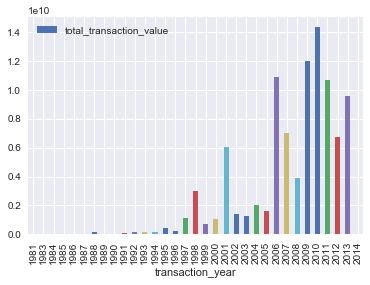

In [118]:
iso = "UGA"
query =(f"SELECT transaction_year, sum(transaction_value) as total_transaction_value, transaction_currency FROM aiddata_transactions WHERE iso_a3 = '{iso}' GROUP BY transaction_year, transaction_currency ORDER BY transaction_year, transaction_currency")

account = 'i2i-admin'
urlCarto = f"https://{account}.carto.com/api/v2/sql"

sql = {"q": query}
r = requests.get(urlCarto, params=sql)

data = r.json().get('rows')
df = pd.DataFrame.from_dict(json_normalize(data))

df.plot(x='transaction_year', y='total_transaction_value', kind='bar');

## Electrical Grid
**Number of lines and total length (numeric)**

Polygon 

```sql
WITH b as (SELECT ST_Setsrid(ST_Geomfromgeojson('
{"type":"Polygon","coordinates":[[[30.618896484375,-0.5053645409602877],[31.651611328125004,-0.5053645409602877],[31.651611328125004,0.208739772610497],[30.618896484375,0.208739772610497],[30.618896484375,-0.5053645409602877]]]}'),4326) as the_geom)

SELECT iso, count(*) as total_lines, sum(ST_Length(ST_Transform(ST_Intersection(b.the_geom, e.the_geom), 26986))/1000.) as total_length_km
    FROM electrical_grid as e, b
   WHERE ST_Intersects(b.the_geom, e.the_geom)
GROUP BY iso
ORDER BY iso
```

*widget_config*

In [69]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'geojson'
            }           
        ],
        'url': 'https://i2i-admin.carto.com/api/v2/sql',
        'sql_query_param': 'q',
        'sql_query': 'WITH b as (SELECT ST_Setsrid(ST_Geomfromgeojson({{geojson}}),4326) as the_geom) SELECT iso, count(*) as total_lines, sum(ST_Length(ST_Transform(ST_Intersection(b.the_geom, e.the_geom), 26986))/1000.) as total_length_km FROM electrical_grid as e, b WHERE ST_Intersects(b.the_geom, e.the_geom) GROUP BY iso ORDER BY iso',
      
        'type': 'text'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "url": "https://i2i-admin.carto.com/api/v2/sql", "sql_query_param": "q", "sql_query": "WITH b as (SELECT ST_Setsrid(ST_Geomfromgeojson({{geojson}}),4326) as the_geom) SELECT iso, count(*) as total_lines, sum(ST_Length(ST_Transform(ST_Intersection(b.the_geom, e.the_geom), 26986))/1000.) as total_length_km FROM electrical_grid as e, b WHERE ST_Intersects(b.the_geom, e.the_geom) GROUP BY iso ORDER BY iso", "type": "text"}}'

Country

```sql
SELECT iso, count(*) as total_lines, sum(length_km) as total_length_km
FROM electrical_grid
WHERE iso = 'UGA'
GROUP BY iso
```

*widget_config*

In [70]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'iso'
            }           
        ],
        'url': 'https://i2i-admin.carto.com/api/v2/sql',
        'sql_query_param': 'q',
        'sql_query': 'SELECT iso, count(*) as total_lines, sum(length_km) as total_length_km FROM electrical_grid WHERE iso = {{iso}} GROUP BY iso',
      
        'type': 'text'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "iso"}], "url": "https://i2i-admin.carto.com/api/v2/sql", "sql_query_param": "q", "sql_query": "SELECT iso, count(*) as total_lines, sum(length_km) as total_length_km FROM electrical_grid WHERE iso = {{iso}} GROUP BY iso", "type": "text"}}'

**Example numbers with python**

In [ ]:
iso = "UGA"
query =("SELECT iso, count(*) as total_lines, sum(length_km) as total_length_km "
"FROM electrical_grid "
"WHERE iso = 'UGA' "
"GROUP BY iso "
"ORDER BY iso "
)

account = 'ikerey'
urlCarto = f"https://{account}.carto.com/api/v2/sql"

sql = {"q": query}
r = requests.get(urlCarto, params=sql)

data = r.json().get('rows')
df = pd.DataFrame.from_dict(json_normalize(data))
df.head()

## Movile Coverage
**Percentage area covered by GSM, 3G, and 4G (chart)**

Polygon 

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('{"type":"Polygon","coordinates":[[[30.618896484375,-0.5053645409602877],[31.651611328125004,-0.5053645409602877],[31.651611328125004,0.208739772610497],[30.618896484375,0.208739772610497],[30.618896484375,-0.5053645409602877]]]}'),4326) as the_geom),
c as (SELECT round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_gsm, round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_3g, round(((a4g.area_4g/atot.area_tot)*100)::numeric, 1) as area_percentage_4g
FROM (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_gsm
        FROM mobile_coverage_global_gsm as m, b 
       WHERE ST_Intersects(m.the_geom, b.the_geom)
      ) as gsm,
      (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_3g
        FROM mobile_coverage_global_3g as m, b 
       WHERE ST_Intersects(m.the_geom, b.the_geom)
      ) as a3g,
     (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_4g
        FROM mobile_coverage_global_4g as m, b 
       WHERE ST_Intersects(m.the_geom, b.the_geom)
      ) as a4g,
     (SELECT ST_Area(b.the_geom) as area_tot
        FROM b 
      ) as atot ) 
SELECT area_percentage_gsm as value, 'GSM' as label, '%' as unit, 'Movile coverage (%)' as title
FROM c
UNION ALL
SELECT area_percentage_3g, '3G', '%', 'Movile coverage (%)'
FROM c
UNION ALL
SELECT area_percentage_4g, '4G', '%', 'Movile coverage (%)'
FROM c
```

In [ ]:
'WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom), c as (SELECT round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_gsm, round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_3g, round(((a4g.area_4g/atot.area_tot)*100)::numeric, 1) as area_percentage_4g FROM (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_gsm FROM mobile_coverage_global_gsm as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as gsm,(SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_3g FROM mobile_coverage_global_3g as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as a3g,(SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_4g FROM mobile_coverage_global_4g as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as a4g,(SELECT ST_Area(b.the_geom) as area_tot FROM b) as atot ) SELECT area_percentage_gsm as value, \'GSM\' as label, \'%\' as unit, \'Movile coverage (%)\' as title FROM c UNION ALL SELECT area_percentage_3g, \'3G\', \'%\', \'Movile coverage (%)\' FROM c UNION ALL SELECT area_percentage_4g, \'4G\', \'%\', \'Movile coverage (%)\' FROM c'

*widget_config*

In [13]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'geojson'
            }           
        ],
        'url': 'https://i2i-admin.carto.com/api/v2/sql',
        'sql_query_param': 'q',
        'sql_query': 'WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom), c as (SELECT round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_gsm, round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_3g, round(((a4g.area_4g/atot.area_tot)*100)::numeric, 1) as area_percentage_4g FROM (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_gsm FROM mobile_coverage_global_gsm as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as gsm,(SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_3g FROM mobile_coverage_global_3g as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as a3g,(SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_4g FROM mobile_coverage_global_4g as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as a4g,(SELECT ST_Area(b.the_geom) as area_tot FROM b) as atot ) SELECT area_percentage_gsm as value, \'GSM\' as label, \'%\' as unit, \'Movile coverage (%)\' as title FROM c UNION ALL SELECT area_percentage_3g, \'3G\', \'%\', \'Movile coverage (%)\' FROM c UNION ALL SELECT area_percentage_4g, \'4G\', \'%\', \'Movile coverage (%)\' FROM c',
      
        'type': 'stacked-bar'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "url": "https://i2i-admin.carto.com/api/v2/sql", "sql_query_param": "q", "sql_query": "WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom), c as (SELECT round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_gsm, round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_3g, round(((a4g.area_4g/atot.area_tot)*100)::numeric, 1) as area_percentage_4g FROM (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_gsm FROM mobile_coverage_global_gsm as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as gsm,(SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_3g FROM mobile_coverage_global_3g as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as a3g,(SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_4g FROM mobile_coverage_global_4g as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as a4g,(SELECT ST_Area(

Country

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b 
            WHERE b.iso_a3 = 'UGA'),
c as (SELECT round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_gsm, round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_3g, round(((a4g.area_4g/atot.area_tot)*100)::numeric, 1) as area_percentage_4g
FROM (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_gsm
        FROM mobile_coverage_global_gsm as m, b 
       WHERE ST_Intersects(m.the_geom, b.the_geom)
      ) as gsm,
      (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_3g
        FROM mobile_coverage_global_3g as m, b 
       WHERE ST_Intersects(m.the_geom, b.the_geom)
      ) as a3g,
     (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_4g
        FROM mobile_coverage_global_4g as m, b 
       WHERE ST_Intersects(m.the_geom, b.the_geom)
      ) as a4g,
     (SELECT ST_Area(b.the_geom) as area_tot
        FROM b 
      ) as atot ) 
SELECT area_percentage_gsm as value, 'GSM' as label, '%' as unit, 'Movile coverage (%)' as title
FROM c
UNION ALL
SELECT area_percentage_3g, '3G', '%', 'Movile coverage (%)'
FROM c
UNION ALL
SELECT area_percentage_4g, '4G', '%', 'Movile coverage (%)'
FROM c         
```

*widget_config*

In [14]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'iso'
            }           
        ],
        'url': 'https://i2i-admin.carto.com/api/v2/sql',
        'sql_query_param': 'q',
        'sql_query': 'WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}), c as (SELECT round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_gsm, round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_3g, round(((a4g.area_4g/atot.area_tot)*100)::numeric, 1) as area_percentage_4g FROM (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_gsm FROM mobile_coverage_global_gsm as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as gsm,(SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_3g FROM mobile_coverage_global_3g as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as a3g,(SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_4g FROM mobile_coverage_global_4g as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as a4g, (SELECT ST_Area(b.the_geom) as area_tot FROM b) as atot ) SELECT area_percentage_gsm as value, \'GSM\' as label, \'%\' as unit, \'Movile coverage (%)\' as title FROM c UNION ALL SELECT area_percentage_3g, \'3G\', \'%\', \'Movile coverage (%)\' FROM c UNION ALL SELECT area_percentage_4g, \'4G\', \'%\', \'Movile coverage (%)\' FROM c',
      
        'type': 'stacked-bar'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "iso"}], "url": "https://i2i-admin.carto.com/api/v2/sql", "sql_query_param": "q", "sql_query": "WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}), c as (SELECT round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_gsm, round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_3g, round(((a4g.area_4g/atot.area_tot)*100)::numeric, 1) as area_percentage_4g FROM (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_gsm FROM mobile_coverage_global_gsm as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as gsm,(SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_3g FROM mobile_coverage_global_3g as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as a3g,(SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_4g FROM mobile_coverage_global_4g as m, b WHERE ST_Intersects(m.the_geom, b.the_geom)) as a4g, (SELECT ST_Area(b.t

## Urban Areas
**Percentage of Urban and Rural areas (chart)**

Polygon

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('
{"type":"Polygon","coordinates":[[[36.5570068359375,-1.4006173190275208],[37.056884765625,-1.4006173190275208],[37.056884765625,-1.1534865266428445],[36.5570068359375,-1.1534865266428445],[36.5570068359375,-1.4006173190275208]]]}'),4326) as the_geom),
     u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom 
             FROM urban_areas as u, b
            WHERE ST_Intersects(b.the_geom, u.the_geom)),
     tot as (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop
            FROM population_count_2015, b 
            WHERE ST_Intersects(the_raster_webmercator, b.the_geom)),
     urb as (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop
            FROM population_count_2015, u 
            WHERE ST_Intersects(the_raster_webmercator, u.the_geom))

SELECT round(((COALESCE(urb.pop,tot.pop)/tot.pop)*100)::numeric, 1) as value, 'urban' as label, '%' as unit
FROM tot, urb
UNION
SELECT round((((tot.pop - COALESCE(urb.pop,tot.pop))/tot.pop)*100)::numeric,1) as value, 'rural' as label, '%' as unit
FROM tot, urb
```

*widget_config*

In [154]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'geojson'
            }           
        ],
        'url': 'https://i2i-admin.carto.com/api/v2/sql',
        'sql_query_param': 'q',
        'sql_query': 'WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom), u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u, b WHERE ST_Intersects(b.the_geom, u.the_geom)), tot as (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop FROM population_count_2015, b WHERE ST_Intersects(the_raster_webmercator, b.the_geom)), urb as (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop FROM population_count_2015, u WHERE ST_Intersects(the_raster_webmercator, u.the_geom)) SELECT round(((COALESCE(urb.pop,tot.pop)/tot.pop)*100)::numeric, 1) as value, \'urban\' as label, \'%\' as unit FROM tot, urb UNION SELECT round((((tot.pop - COALESCE(urb.pop,tot.pop))/tot.pop)*100)::numeric,1) as value, \'rural\' as label, \'%\' as unit FROM tot, urb',
        'type': 'pie'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "url": "https://i2i-admin.carto.com/api/v2/sql", "sql_query_param": "q", "sql_query": "WITH b as (SELECT st_setsrid(st_geomfromgeojson({{geojson}}),4326) as the_geom), u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u, b WHERE ST_Intersects(b.the_geom, u.the_geom)), tot as (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop FROM population_count_2015, b WHERE ST_Intersects(the_raster_webmercator, b.the_geom)), urb as (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop FROM population_count_2015, u WHERE ST_Intersects(the_raster_webmercator, u.the_geom)) SELECT round(((COALESCE(urb.pop,tot.pop)/tot.pop)*100)::numeric, 1) as value, \'urban\' as label, \'%\' as unit FROM tot, urb UNION SELECT round((((tot.pop - COALESCE(urb.pop,tot.pop))/tot.pop)*100)::numeric,1) as value, \'rural\' as 

Country

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b 
            WHERE b.iso_a3 = 'UGA'),
     u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u
             JOIN world_borders_hd as b
               ON ST_Intersects(b.the_geom, u.the_geom)
            WHERE b.iso_a3 = 'UGA'),
     tot as (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop
            FROM population_count_2015, b 
            WHERE ST_Intersects(the_raster_webmercator, b.the_geom)),
     urb as (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop
            FROM population_count_2015, u 
            WHERE ST_Intersects(the_raster_webmercator, u.the_geom))

SELECT round(((COALESCE(urb.pop,tot.pop)/tot.pop)*100)::numeric, 1) as value, 'urban' as label, '%' as unit 
FROM tot, urb
UNION
SELECT round((((tot.pop - COALESCE(urb.pop,tot.pop))/tot.pop)*100)::numeric,1) as value, 'rural' as label, '%' as unit
FROM tot, urb
```

*widget_config*

In [155]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'iso'
            }           
        ],
        'url': 'https://i2i-admin.carto.com/api/v2/sql',
        'sql_query_param': 'q',
        'sql_query': 'WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}), u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u JOIN world_borders_hd as b ON ST_Intersects(b.the_geom, u.the_geom) WHERE b.iso_a3 = {{iso}}), tot as (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop FROM population_count_2015, b WHERE ST_Intersects(the_raster_webmercator, b.the_geom)), urb as (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop FROM population_count_2015, u WHERE ST_Intersects(the_raster_webmercator, u.the_geom)) SELECT round(((COALESCE(urb.pop,tot.pop)/tot.pop)*100)::numeric, 1) as value, \'urban\' as label, \'%\' as unit FROM tot, urb UNION SELECT round((((tot.pop - COALESCE(urb.pop,tot.pop))/tot.pop)*100)::numeric,1) as value, \'rural\' as label, \'%\' as unit FROM tot, urb',
        'type': 'pie'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "iso"}], "url": "https://i2i-admin.carto.com/api/v2/sql", "sql_query_param": "q", "sql_query": "WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = {{iso}}), u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u JOIN world_borders_hd as b ON ST_Intersects(b.the_geom, u.the_geom) WHERE b.iso_a3 = {{iso}}), tot as (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop FROM population_count_2015, b WHERE ST_Intersects(the_raster_webmercator, b.the_geom)), urb as (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop FROM population_count_2015, u WHERE ST_Intersects(the_raster_webmercator, u.the_geom)) SELECT round(((COALESCE(urb.pop,tot.pop)/tot.pop)*100)::numeric, 1) as value, \'urban\' as label, \'%\' as unit FROM tot, urb UNION SELECT round((((tot.pop - COALESCE(urb.pop,tot.pop))/tot.pop

## [Accessibility to Cities](https://resourcewatch.org/data/explore/cit01701-Travel-Time-to-Major-Cities)  
**Time to reach a city (numeric)** 
[dataset](http://api.resourcewatch.org/v1/dataset/ccbcaf7b-1619-4298-8275-b135d1e8e04e)

In [36]:
slug = 'cit01701-Travel-Time-to-Major-Cities'
sql = "SELECT ST_SUMMARYSTATS() as stats FROM 'cit01701-Travel-Time-to-Major-Cities' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON('{\"type\":\"Polygon\",\"coordinates\":[[[36.507568359375,-1.6037944300589726],[37.15576171875,-1.6037944300589726],[37.15576171875,-0.9887204566941844],[36.507568359375,-0.9887204566941844],[36.507568359375,-1.6037944300589726]]]}'),4326))"

params={"sql": sql}
url = "https://api.resourcewatch.org/v1/query"
r = requests.get(f"{url}", params)
r.url

'https://api.resourcewatch.org/v1/query?sql=SELECT+ST_SUMMARYSTATS%28%29+as+stats+FROM+%27cit01701-Travel-Time-to-Major-Cities%27+WHERE+ST_INTERSECTS%28the_geom%2C+ST_SetSRID%28ST_GeomFromGeoJSON%28%27%7B%22type%22%3A%22Polygon%22%2C%22coordinates%22%3A%5B%5B%5B36.507568359375%2C-1.6037944300589726%5D%2C%5B37.15576171875%2C-1.6037944300589726%5D%2C%5B37.15576171875%2C-0.9887204566941844%5D%2C%5B36.507568359375%2C-0.9887204566941844%5D%2C%5B36.507568359375%2C-1.6037944300589726%5D%5D%5D%7D%27%29%2C4326%29%29'

In [37]:
r.json()

{'data': [{'stats': {'accessibility': {'count': 5925,
     'max': 143,
     'mean': 21.50045187358482,
     'min': 0,
     'stdev': 22.65017824069809,
     'sum': 123429.8784313725}}}],
 'meta': {}}

*widget_config*

In [95]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'geojson'
            }   
        ],
        'url': 'https://api.resourcewatch.org/v1/query',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT ST_SUMMARYSTATS() as stats FROM \'cit01701-Travel-Time-to-Major-Cities\' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326))',        
        'type': 'text'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "url": "https://api.resourcewatch.org/v1/query", "sql_query_param": "sql", "sql_query": "SELECT ST_SUMMARYSTATS() as stats FROM \'cit01701-Travel-Time-to-Major-Cities\' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326))", "type": "text"}}'

## [Population (Grid, 1 km)](https://resourcewatch.org/data/explore/soc_031-Gridded-Population)
**Population density per year (chart)**
[dataset](http://api.resourcewatch.org/v1/dataset/595bcf6f-0343-4146-ba0d-c54b1c928510)

In [39]:
sql = "SELECT ST_SUMMARYSTATS() as stats FROM 'soc072-Population-Grid-250-m' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON('{\"type\":\"Polygon\",\"coordinates\":[[[36.507568359375,-1.6037944300589726],[37.15576171875,-1.6037944300589726],[37.15576171875,-0.9887204566941844],[36.507568359375,-0.9887204566941844],[36.507568359375,-1.6037944300589726]]]}'),4326))"

params={"sql": sql}
url = "https://api.resourcewatch.org/v1/query"
r = requests.get(f"{url}", params)
r.json()

{'data': [{'stats': {'year1975': {'count': 306720,
     'max': 20655.798828125,
     'mean': 20.634323809428864,
     'min': 0,
     'stdev': 206.00404458625172,
     'sum': 6304688.088785033},
    'year1990': {'count': 306720,
     'max': 13113.0048828125,
     'mean': 37.01764362550635,
     'min': 0,
     'stdev': 257.3968380953515,
     'sum': 11310508.59703839},
    'year2000': {'count': 306720,
     'max': 14453.2607421875,
     'mean': 50.01269684336052,
     'min': 0,
     'stdev': 311.68809654028195,
     'sum': 15281065.51920392},
    'year2015': {'count': 306720,
     'max': 26782,
     'mean': 73.91719650762954,
     'min': 0,
     'stdev': 418.2777900472471,
     'sum': 22584935.308860682}}}],
 'meta': {}}

In [25]:
r.url

'https://api.resourcewatch.org/v1/query?sql=SELECT+ST_SUMMARYSTATS%28%29+FROM+%27soc072-Population-Grid-250-m%27+WHERE+ST_INTERSECTS%28the_geom%2C+ST_SetSRID%28ST_GeomFromGeoJSON%28%27%7B%22type%22%3A%22Polygon%22%2C%22coordinates%22%3A%5B%5B%5B36.507568359375%2C-1.6037944300589726%5D%2C%5B37.15576171875%2C-1.6037944300589726%5D%2C%5B37.15576171875%2C-0.9887204566941844%5D%2C%5B36.507568359375%2C-0.9887204566941844%5D%2C%5B36.507568359375%2C-1.6037944300589726%5D%5D%5D%7D%27%29%2C4326%29%29'

*widget_config*

In [76]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'geojson'
            }   
        ],
        'url': 'https://api.resourcewatch.org/v1/query',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT ST_SUMMARYSTATS() as stats FROM \'soc072-Population-Grid-250-m\' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326))',        
        'type': 'stacked-bar'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "url": "https://api.resourcewatch.org/v1/query", "sql_query_param": "sql", "sql_query": "SELECT ST_SUMMARYSTATS() as stats FROM \'soc072-Population-Grid-250-m\' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326))", "type": "stacked-bar"}}'

## [Urban Built-Up Area](https://resourcewatch.org/data/explore/Cit014-Built-Up-Grid)
**Built-Up Areas (%) per year (chart)**
[dataset](http://api.resourcewatch.org/v1/dataset/f6bb99af-541a-4d41-9e47-cc36cb479d4b)

In [39]:
{'b1': '1975 Built-Up Areas (%)', 'b2': '1990 Built-Up Areas (%)', 'b3': '2000 Built-Up Areas (%)', 'b4': '2014 Built-Up Areas (%)'}

{'b1': '1975 Built-Up Areas (%)',
 'b2': '1990 Built-Up Areas (%)',
 'b3': '2000 Built-Up Areas (%)',
 'b4': '2014 Built-Up Areas (%)'}

In [42]:
sql = "SELECT ST_SUMMARYSTATS() as stats FROM 'Cit014-Built-Up-Grid' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON('{\"type\":\"Polygon\",\"coordinates\":[[[36.7987060546875,-1.2942167094566774],[36.82548522949219,-1.2942167094566774],[36.82548522949219,-1.271563087631464],[36.7987060546875,-1.271563087631464],[36.7987060546875,-1.2942167094566774]]]}'),4326))"

params={"sql": sql}
url = "https://api.resourcewatch.org/v1/query"
r = requests.get(f"{url}", params)
r.json()

{'data': [{'stats': {'b1': {'count': 119,
     'max': 0.867158830165863,
     'mean': 0.15315479725326048,
     'min': 0,
     'stdev': 0.1801299923705741,
     'sum': 14.875835366151984},
    'b2': {'count': 119,
     'max': 0.983106791973114,
     'mean': 0.2923071597571166,
     'min': 0,
     'stdev': 0.30780335532103165,
     'sum': 28.391622481820644},
    'b3': {'count': 119,
     'max': 0.9919904470443726,
     'mean': 0.3164469165443291,
     'min': 0,
     'stdev': 0.3205172815396378,
     'sum': 30.736302858705663},
    'b4': {'count': 119,
     'max': 1,
     'mean': 0.3765611606713531,
     'min': 0,
     'stdev': 0.33403026875520064,
     'sum': 36.57516402944343}}}],
 'meta': {}}

*widget_config*

In [77]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'geojson'
            }   
        ],
        'url': 'https://api.resourcewatch.org/v1/query',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT ST_SUMMARYSTATS() as stats FROM \'Cit014-Built-Up-Grid\' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326))',        
        'type': 'stacked-bar'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "url": "https://api.resourcewatch.org/v1/query", "sql_query_param": "sql", "sql_query": "SELECT ST_SUMMARYSTATS() as stats FROM \'Cit014-Built-Up-Grid\' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326))", "type": "stacked-bar"}}'

## [Agricultural Exposure to Water Stress](https://resourcewatch.org/data/explore/wat033-Agriculture-Water-Demand-and-Depletion)
**Area covered by category (chart)** 
[dataset](http://api.resourcewatch.org/v1/dataset/05c330d7-49cf-42d6-bada-e255b8c8e115)

```html
https://api.resourcewatch.org/v1/query/05c330d7-49cf-42d6-bada-e255b8c8e115?sql=SELECT sum(area_km2) as value, ws2024tl as label, 'km2' as unit FROM aqueduct_projections_20150309 WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON('{"type":"Polygon","coordinates":[[[35.44189453125,-6.533645130567532],[42.0556640625,-6.533645130567532],[42.0556640625,0.6591651462894632],[35.44189453125,0.6591651462894632],[35.44189453125,-6.533645130567532]]]}'),4326)) GROUP BY ws2024tl
```

*widget_config*

In [78]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'geojson'
            }   
        ],
        'url': 'https://api.resourcewatch.org/v1/query/05c330d7-49cf-42d6-bada-e255b8c8e115',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT sum(area_km2) as value, ws2024tl as label, \'km2\' as unit FROM aqueduct_projections_20150309 WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326)) GROUP BY ws2024tl',        
        'type': 'stacked-bar'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "url": "https://api.resourcewatch.org/v1/query/05c330d7-49cf-42d6-bada-e255b8c8e115", "sql_query_param": "sql", "sql_query": "SELECT sum(area_km2) as value, ws2024tl as label, \'km2\' as unit FROM aqueduct_projections_20150309 WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326)) GROUP BY ws2024tl", "type": "stacked-bar"}}'

## [Erosion Risk](https://resourcewatch.org/data/explore/wat015-Erosion-Risk)
**Erosion risk (%) (chart)**
[dataset](http://api.resourcewatch.org/v1/dataset/e6e83d98-aa1f-495f-916c-b33d0657e0fe)

In [41]:
{1:'Low', 2:'Low-Medium', 3:'Medium', 4:'Medium-High', 5:'High'}

{1: 'Low', 2: 'Low-Medium', 3: 'Medium', 4: 'Medium-High', 5: 'High'}

In [47]:
sql = "SELECT ST_HISTOGRAM(raster, wat_015_erosion, 5, true) as histogram FROM 'wat015-Erosion-Risk' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON('{\"type\":\"Polygon\",\"coordinates\":[[[36.507568359375,-1.6037944300589726],[37.15576171875,-1.6037944300589726],[37.15576171875,-0.9887204566941844],[36.507568359375,-0.9887204566941844],[36.507568359375,-1.6037944300589726]]]}'),4326))"

params={"sql": sql}
url = "https://api.resourcewatch.org/v1/query"
r = requests.get(f"{url}", params)
r.json()

{'data': [{'histogram': {'wat_015_erosion': [[1, 7173.964705882352],
     [2, 4064.2313725490203],
     [3, 10316.180392156864],
     [4, 30312.643137254912],
     [5, 6135.972549019612]]}}],
 'meta': {}}

*widget_config*

In [79]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'geojson'
            }   
        ],
        'url': 'https://api.resourcewatch.org/v1/query',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT ST_HISTOGRAM(raster, wat_015_erosion, 5, true) as histogram FROM \'wat015-Erosion-Risk\' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326))',        
        'type': 'pie'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "url": "https://api.resourcewatch.org/v1/query", "sql_query_param": "sql", "sql_query": "SELECT ST_HISTOGRAM(raster, wat_015_erosion, 5, true) as histogram FROM \'wat015-Erosion-Risk\' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326))", "type": "bar"}}'

## [Annual Precipitation](https://resourcewatch.org/data/explore/wat034-Annual-Precipitation)
**No info**
[dataset](http://api.resourcewatch.org/v1/dataset/12510410-1eb3-4af0-844f-8a05be50b1c1)

## [Aridity](https://resourcewatch.org/data/explore/cli030-Land-Aridity)
**Aridity Index (numeric)**
[dataset](http://api.resourcewatch.org/v1/dataset/99075509-df36-461e-abb0-659cee555bd0)

In [50]:
sql = "SELECT ST_SUMMARYSTATS() as stats FROM 'cli030-Land-Aridity' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON('{\"type\":\"Polygon\",\"coordinates\":[[[36.507568359375,-1.6037944300589726],[37.15576171875,-1.6037944300589726],[37.15576171875,-0.9887204566941844],[36.507568359375,-0.9887204566941844],[36.507568359375,-1.6037944300589726]]]}'),4326))"

params={"sql": sql}
url = "https://api.resourcewatch.org/v1/query"
r = requests.get(f"{url}", params)
r.json()

{'data': [{'stats': {'b1': {'count': 5925,
     'max': 10454,
     'mean': 5364.989310774512,
     'min': 3060,
     'stdev': 1600.9871074653056,
     'sum': 30799330.635294136}}}],
 'meta': {}}

*widget_config*

In [96]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'geojson'
            }   
        ],
        'url': 'https://api.resourcewatch.org/v1/query',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT ST_SUMMARYSTATS() as stats FROM \'cli030-Land-Aridity\' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326))',        
        'type': 'text'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "url": "https://api.resourcewatch.org/v1/query", "sql_query_param": "sql", "sql_query": "SELECT ST_SUMMARYSTATS() as stats FROM \'cli030-Land-Aridity\' WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326))", "type": "text"}}'

## [Roads](https://resourcewatch.org/data/explore/cit016-Road-Network)
**Number of lines and total length in km (numeric)**
[dataset](http://api.resourcewatch.org/v1/dataset/943f3702-421f-47a4-9b99-e2d5a9f544a7)

```html
https://api.resourcewatch.org/v1/query/943f3702-421f-47a4-9b99-e2d5a9f544a7?sql=SELECT count(*) as total_lines, sum(length_km) as total_length_km FROM cit_016_road_network
WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON('{"type":"Polygon","coordinates":[[[30.618896484375,-0.5053645409602877],[31.651611328125004,-0.5053645409602877],[31.651611328125004,0.208739772610497],[30.618896484375,0.208739772610497],[30.618896484375,-0.5053645409602877]]]}'),4326))
GROUP BY exs
```

*widget_config*

In [80]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'geojson'
            }   
        ],
        'url': 'https://api.resourcewatch.org/v1/query/943f3702-421f-47a4-9b99-e2d5a9f544a7',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT count(*) as total_lines, sum(length_km) as total_length_km FROM cit_016_road_network WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326)) GROUP BY exs',        
        'type': 'text'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "url": "https://api.resourcewatch.org/v1/query/943f3702-421f-47a4-9b99-e2d5a9f544a7", "sql_query_param": "sql", "sql_query": "SELECT count(*) as total_lines, sum(length_km) as total_length_km FROM cit_016_road_network WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326)) GROUP BY exs", "type": "text"}}'

## [Roadless Areas](https://resourcewatch.org/data/explore/Global-Roadless-Areas)
**Mean roadless area in km^2 (numeric)**
[dataset](http://api.resourcewatch.org/v1/dataset/a07f1bed-ca16-4fbf-b14b-d3a0344cab74)

```html
https://api.resourcewatch.org/v1/query/a07f1bed-ca16-4fbf-b14b-d3a0344cab74?sql=SELECT avg(area_km) as mean_roadless_area_km2 FROM bio_017_global_roadless_areas
WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON('{"type":"Polygon","coordinates":[[[30.618896484375,-0.5053645409602877],[31.651611328125004,-0.5053645409602877],[31.651611328125004,0.208739772610497],[30.618896484375,0.208739772610497],[30.618896484375,-0.5053645409602877]]]}'),4326))
GROUP BY continent
```

*widget_config*

In [81]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'geojson'
            }   
        ],
        'url': 'https://api.resourcewatch.org/v1/query/a07f1bed-ca16-4fbf-b14b-d3a0344cab74',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT avg(area_km) as mean_roadless_area_km2 FROM bio_017_global_roadless_areas WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326)) GROUP BY continent',        
        'type': 'text'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "url": "https://api.resourcewatch.org/v1/query/a07f1bed-ca16-4fbf-b14b-d3a0344cab74", "sql_query_param": "sql", "sql_query": "SELECT avg(area_km) as mean_roadless_area_km2 FROM bio_017_global_roadless_areas WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326)) GROUP BY continent", "type": "text"}}'

## [Current Water Risk](https://resourcewatch.org/data/explore/wat001-Baseline-Water-Stress)
**Total withdrawal, consumption, and baseline water stress per category (chart)**
[dataset](http://api.resourcewatch.org/v1/dataset/d7c3d954-ac86-4d1a-bb6a-c8c432a94e26)

```html
https://api.resourcewatch.org/v1/query/d7c3d954-ac86-4d1a-bb6a-c8c432a94e26?sql=SELECT sum(withdrawal) as total_withdrawal_m3, sum(consumptio) as total_consumption_m3, sum(bws) as value, bws_cat as label FROM wat_001_current_water_stress WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON('{"type":"Polygon","coordinates":[[[35.44189453125,-6.533645130567532],[42.0556640625,-6.533645130567532],[42.0556640625,0.6591651462894632],[35.44189453125,0.6591651462894632],[35.44189453125,-6.533645130567532]]]}'),4326)) GROUP BY bws_cat
```

*widget_config*

In [82]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'geojson'
            }   
        ],
        'url': 'https://api.resourcewatch.org/v1/query/d7c3d954-ac86-4d1a-bb6a-c8c432a94e26',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT sum(withdrawal) as total_withdrawal_m3, sum(consumptio) as total_consumption_m3, sum(bws) as value, bws_cat as label FROM wat_001_current_water_stress WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326)) GROUP BY bws_cat',        
        'type': 'stacked-bar'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "url": "https://api.resourcewatch.org/v1/query/d7c3d954-ac86-4d1a-bb6a-c8c432a94e26", "sql_query_param": "sql", "sql_query": "SELECT sum(withdrawal) as total_withdrawal_m3, sum(consumptio) as total_consumption_m3, sum(bws) as value, bws_cat as label FROM wat_001_current_water_stress WHERE ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326)) GROUP BY bws_cat", "type": "stacked-bar"}}'

## [Reservoirs and Dams](https://resourcewatch.org/data/explore/Global-Reservoir-and-Dam-GRanD)
**Global Dams by Primary Use (chart)**
[dataset](http://api.resourcewatch.org/v1/dataset/e63bb157-4b98-4ecb-81d6-c1b15e79895a)

```html
https://api.resourcewatch.org/v1/query/e63bb157-4b98-4ecb-81d6-c1b15e79895a?sql=SELECT main_use as label, COUNT(main_use) as value FROM grand_dams WHERE main_use IN ('Fisheries', 'Flood control', 'Hydroelectricity', 'Irrigation', 'Navigation', 'Other', 'Recreation', 'Water supply') AND ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON('{"type":"Polygon","coordinates":[[[35.44189453125,-6.533645130567532],[42.0556640625,-6.533645130567532],[42.0556640625,0.6591651462894632],[35.44189453125,0.6591651462894632],[35.44189453125,-6.533645130567532]]]}'),4326)) GROUP BY  label ORDER BY label DESC LIMIT 20
```

*widget_config*

In [83]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'geojson'
            }   
        ],
        'url': 'https://api.resourcewatch.org/v1/query/e63bb157-4b98-4ecb-81d6-c1b15e79895a',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT main_use as label, COUNT(main_use) as value FROM grand_dams WHERE main_use IN (\'Fisheries\', \'Flood control\', \'Hydroelectricity\', \'Irrigation\', \'Navigation\', \'Other\', \'Recreation\', \'Water supply\') AND ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326)) GROUP BY label ORDER BY label DESC LIMIT 20',        
        'type': 'stacked-bar'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "geojson"}], "url": "https://api.resourcewatch.org/v1/query/e63bb157-4b98-4ecb-81d6-c1b15e79895a", "sql_query_param": "sql", "sql_query": "SELECT main_use as label, COUNT(main_use) as value FROM grand_dams WHERE main_use IN (\'Fisheries\', \'Flood control\', \'Hydroelectricity\', \'Irrigation\', \'Navigation\', \'Other\', \'Recreation\', \'Water supply\') AND ST_INTERSECTS(the_geom, ST_SetSRID(ST_GeomFromGeoJSON({{geojson}}),4326)) GROUP BY label ORDER BY label DESC LIMIT 20", "type": "stacked-bar"}}'

***

# Country contextual information

## [Access to Electricity](https://resourcewatch.org/data/explore/ene012-Access-to-Electricity)  
**Percentage of national, urban and rural access to electricity (%) per year (chart)** 
[dataset](http://api.resourcewatch.org/v1/dataset/d446a52e-c4c1-4e74-ae30-3204620a0365)

```html
https://api.resourcewatch.org/v1/query/d446a52e-c4c1-4e74-ae30-3204620a0365?sql=SELECT date_part('year', datetime) as date, country_name as country, total_data as value1, urban_data as value2, rural_data as value3, 'total' as subcategory1, 'urban' as subcategory2, 'rural' as subcategory3, 'percentage' as unit  FROM ene_012_electricity_access WHERE country_code = 'KEN' ORDER BY date DESC LIMIT 18
```

*widget_config*

In [98]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'iso'
            } 
        ],
        'url': 'https://api.resourcewatch.org/v1/query/d446a52e-c4c1-4e74-ae30-3204620a0365',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT date_part(\'year\', datetime) as date, country_name as country, total_data as value1, urban_data as value2, rural_data as value3, \'total\' as subcategory1, \'urban\' as subcategory2, \'rural\' as subcategory3, \'percentage\' as unit  FROM ene_012_electricity_access WHERE country_code = {{iso}} ORDER BY date DESC LIMIT 18',        
        'type': 'grouped-bar'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "iso"}], "url": "https://api.resourcewatch.org/v1/query/d446a52e-c4c1-4e74-ae30-3204620a0365", "sql_query_param": "sql", "sql_query": "SELECT date_part(\'year\', datetime) as date, country_name as country, total_data as value1, urban_data as value2, rural_data as value3, \'total\' as subcategory1, \'urban\' as subcategory2, \'rural\' as subcategory3, \'percentage\' as unit  FROM ene_012_electricity_access WHERE country_code = {{iso}} ORDER BY date DESC LIMIT 18", "type": "grouped-bar"}}'

## [Adult Literacy Rate](https://resourcewatch.org/data/explore/Adult-Literacy-Rate)  
**2015 Adult Literacy Rate (%) (number)** 
[dataset](http://api.resourcewatch.org/v1/dataset/e8f53f73-d77c-485a-a2a6-1c47ea4aead9)

```html
https://api.resourcewatch.org/v1/query/e8f53f73-d77c-485a-a2a6-1c47ea4aead9?sql=SELECT date_part('year', datetime) as date, rw_country_name as country, yr_data as value, '{%}' as unit FROM soc_015_adult_literacy_rate WHERE country_code = 'KEN' and date_part('year', datetime) = 2015
```

In [ ]:
'SELECT date_part(\'year\', datetime) as date, rw_country_name as country, yr_data as value, \'percentage\' as unit FROM soc_015_adult_literacy_rate WHERE country_code = {{iso}} and date_part(\'year\', datetime) = 2015'

*widget_config*

In [99]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'iso'
            } 
        ],
        'url': 'https://api.resourcewatch.org/v1/query/e8f53f73-d77c-485a-a2a6-1c47ea4aead9',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT date_part(\'year\', datetime) as date, rw_country_name as country, yr_data as value, \'percentage\' as unit FROM soc_015_adult_literacy_rate WHERE country_code = {{iso}} and date_part(\'year\', datetime) = 2015',        
        'type': 'text'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "iso"}], "url": "https://api.resourcewatch.org/v1/query/e8f53f73-d77c-485a-a2a6-1c47ea4aead9", "sql_query_param": "sql", "sql_query": "SELECT date_part(\'year\', datetime) as date, rw_country_name as country, yr_data as value, \'percentage\' as unit FROM soc_015_adult_literacy_rate WHERE country_code = {{iso}} and date_part(\'year\', datetime) = 2015", "type": "text"}}'

## [Child Malnutrition](https://resourcewatch.org/data/explore/Child-Malnutrition)  
**2014 Child Malnutrition (%) per category (chart)** 
[dataset](http://api.resourcewatch.org/v1/dataset/8bc79a36-d77e-4ee3-b9bc-c77146cfc503)

```html
https://api.resourcewatch.org/v1/query/8bc79a36-d77e-4ee3-b9bc-c77146cfc503?sql=SELECT survey_year as year, rw_country_name as country, severe_wasting, stunting, underweight, wasting, overweight FROM foo_019_child_malnutrition_edit WHERE rw_country_code = 'KEN'
```

*widget_config*

In [87]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'iso'
            }
        ],
        'url': 'https://api.resourcewatch.org/v1/query/8bc79a36-d77e-4ee3-b9bc-c77146cfc503',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT survey_year as year, rw_country_name as country, severe_wasting, stunting, underweight, wasting, overweight FROM foo_019_child_malnutrition_edit WHERE rw_country_code = {{iso}}',        
        'type': 'text'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "iso"}], "url": "https://api.resourcewatch.org/v1/query/8bc79a36-d77e-4ee3-b9bc-c77146cfc503", "sql_query_param": "sql", "sql_query": "SELECT survey_year as year, rw_country_name as country, severe_wasting, stunting, underweight, wasting, overweight FROM foo_019_child_malnutrition_edit WHERE rw_country_code = {{iso}}", "type": "text"}}'

## [Current Account Balance](https://resourcewatch.org/data/explore/Current-Account-Balance-BoP-Current-USdollar)  
**Account balance per year (chart)** 
[dataset](http://api.resourcewatch.org/v1/dataset/2e31a1f3-576b-46b4-84f0-3f0cc399f887)

```html
https://api.resourcewatch.org/v1/query/2e31a1f3-576b-46b4-84f0-3f0cc399f887?sql=SELECT date_part('year', datetime) as year, rw_country_name as country, index, indicator_name FROM com_006_national_current_accounts_edit WHERE rw_country_code = 'KEN' ORDER BY year DESC LIMIT 17
```

*widget_config*

In [88]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'iso'
            }
        ],
        'url': 'https://api.resourcewatch.org/v1/query/2e31a1f3-576b-46b4-84f0-3f0cc399f887',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT date_part(\'year\', datetime) as year, rw_country_name as country, index, indicator_name FROM com_006_national_current_accounts_edit WHERE rw_country_code = {{iso}} ORDER BY year DESC LIMIT 17',        
        'type': 'text'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "iso"}], "url": "https://api.resourcewatch.org/v1/query/2e31a1f3-576b-46b4-84f0-3f0cc399f887", "sql_query_param": "sql", "sql_query": "SELECT date_part(\'year\', datetime) as year, rw_country_name as country, index, indicator_name FROM com_006_national_current_accounts_edit WHERE rw_country_code = {{iso}} ORDER BY year DESC LIMIT 17", "type": "text"}}'

## [Gender Development Index](https://resourcewatch.org/data/explore/Gender-Development-Index)  
**2015 Gender Development Index (number)** 
[dataset](http://api.resourcewatch.org/v1/dataset/d4ca3cc4-c162-469c-b341-b52284a73eaa)

```html
https://api.resourcewatch.org/v1/query/d4ca3cc4-c162-469c-b341-b52284a73eaa?sql=SELECT country, gdi_value as index FROM soc_002_gender_development_index WHERE rw_country_code = 'KEN' 
```

*widget_config*

In [89]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'iso'
            }
        ],
        'url': 'https://api.resourcewatch.org/v1/query/d4ca3cc4-c162-469c-b341-b52284a73eaa',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT country, gdi_value as index FROM soc_002_gender_development_index WHERE rw_country_code = {{iso}}',        
        'type': 'text'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "iso"}], "url": "https://api.resourcewatch.org/v1/query/d4ca3cc4-c162-469c-b341-b52284a73eaa", "sql_query_param": "sql", "sql_query": "SELECT country, gdi_value as index FROM soc_002_gender_development_index WHERE rw_country_code = {{iso}}", "type": "text"}}'

## [Gender Inequality Index](https://resourcewatch.org/data/explore/soc025-Gender-Inequality-Index) 
**2015 Gender Inequality Index (number)** 
[dataset](http://api.resourcewatch.org/v1/dataset/11278cb6-b298-49a1-bf71-f1e269f40758)

```html
https://api.resourcewatch.org/v1/query/11278cb6-b298-49a1-bf71-f1e269f40758?sql=SELECT date_part('year', datetime) as year, rw_country_name as country, yr_data as index FROM soc_025_gender_inequality_index WHERE rw_country_code = 'KEN' AND date_part('year', datetime) = 2015
```

*widget_config*

In [90]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'iso'
            } 
        ],
        'url': 'https://api.resourcewatch.org/v1/query/11278cb6-b298-49a1-bf71-f1e269f40758',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT date_part(\'year\', datetime) as year, rw_country_name as country, yr_data as index FROM soc_025_gender_inequality_index WHERE rw_country_code = {{iso}} AND date_part(\'year\', datetime) = 2015',        
        'type': 'text'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "iso"}], "url": "https://api.resourcewatch.org/v1/query/11278cb6-b298-49a1-bf71-f1e269f40758", "sql_query_param": "sql", "sql_query": "SELECT date_part(\'year\', datetime) as year, rw_country_name as country, yr_data as index FROM soc_025_gender_inequality_index WHERE rw_country_code = {{iso}} AND date_part(\'year\', datetime) = 2015", "type": "text"}}'

## [Gross Domestic Product](https://resourcewatch.org/data/explore/Gross-Domestic-Product) 
**Gross Domestic Product per year (chart)** 
[dataset](http://api.resourcewatch.org/v1/dataset/52c55378-0484-48c3-92fc-3ee94d21c716)

```html
https://api.resourcewatch.org/v1/query/52c55378-0484-48c3-92fc-3ee94d21c716?sql=SELECT date_part('year', datetime) as year, country_name as country, yr_data, unit1, indicator_code1 FROM com_010_gdp_ppp_usd WHERE country_code = 'KEN' ORDER BY year DESC LIMIT 18
```

*widget_config*

In [91]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'iso'
            }
        ],
        'url': 'https://api.resourcewatch.org/v1/query/52c55378-0484-48c3-92fc-3ee94d21c716',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT date_part(\'year\', datetime) as year, country_name as country, yr_data, unit1, indicator_code1 FROM com_010_gdp_ppp_usd WHERE country_code = {{iso}} ORDER BY year DESC LIMIT 18',        
        'type': 'text'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "iso"}], "url": "https://api.resourcewatch.org/v1/query/52c55378-0484-48c3-92fc-3ee94d21c716", "sql_query_param": "sql", "sql_query": "SELECT date_part(\'year\', datetime) as year, country_name as country, yr_data, unit1, indicator_code1 FROM com_010_gdp_ppp_usd WHERE country_code = {{iso}} ORDER BY year DESC LIMIT 18", "type": "text"}}'

## [Regulatory Restrictiveness Index](https://resourcewatch.org/data/explore/Regulatory-Restrictiveness-Index) 
**Regulatory Restrictiveness Index (number)** 
[dataset](http://api.resourcewatch.org/v1/dataset/fe311144-8c0e-4440-b068-6efd057e0f6a)

```html
https://api.resourcewatch.org/v1/query/fe311144-8c0e-4440-b068-6efd057e0f6a?sql=SELECT rw_country_name as country, total_fdi_index as index FROM com_007_fdi_index WHERE rw_country_code = 'IND' 
```

*widget_config*

In [92]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'iso'
            }
        ],
        'url': 'https://api.resourcewatch.org/v1/query/fe311144-8c0e-4440-b068-6efd057e0f6a',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT rw_country_name as country, total_fdi_index as index FROM com_007_fdi_index WHERE rw_country_code = {{iso}}',        
        'type': 'text'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "iso"}], "url": "https://api.resourcewatch.org/v1/query/fe311144-8c0e-4440-b068-6efd057e0f6a", "sql_query_param": "sql", "sql_query": "SELECT rw_country_name as country, total_fdi_index as index FROM com_007_fdi_index WHERE rw_country_code = {{iso}}", "type": "text"}}'

## [Urban Population Living in Slums](https://resourcewatch.org/data/explore/Percent-of-Urban-Population-living-in-Slums)
**2014 Urban Population Living in Slums percentage (number)** 
[dataset](http://api.resourcewatch.org/v1/dataset/35ce2b98-adbb-4873-b334-d7b1cc542de7)

```html
https://api.resourcewatch.org/v1/query/35ce2b98-adbb-4873-b334-d7b1cc542de7?sql=SELECT date_part('year', datetime) as year, country_name as country, yr_data as percentage, indicator_name FROM cit_028_percent_urban_slums_edit WHERE rw_country_code = 'KEN' and date_part('year', datetime) = 2014 
```

*widget_config*

In [93]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'iso'
            }
        ],
        'url': 'https://api.resourcewatch.org/v1/query/35ce2b98-adbb-4873-b334-d7b1cc542de7',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT date_part(\'year\', datetime) as year, country_name as country, yr_data as percentage, indicator_name FROM cit_028_percent_urban_slums_edit WHERE rw_country_code = {{iso}} and date_part(\'year\', datetime) = 2014',        
        'type': 'text'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "iso"}], "url": "https://api.resourcewatch.org/v1/query/35ce2b98-adbb-4873-b334-d7b1cc542de7", "sql_query_param": "sql", "sql_query": "SELECT date_part(\'year\', datetime) as year, country_name as country, yr_data as percentage, indicator_name FROM cit_028_percent_urban_slums_edit WHERE rw_country_code = {{iso}} and date_part(\'year\', datetime) = 2014", "type": "text"}}'

## [Vulnerability to Climate Change Index](https://resourcewatch.org/data/explore/Vulnerability-to-Climate-Change-Index) 
**2015 Global Adaptation Index (number)** 
[dataset](http://api.resourcewatch.org/v1/dataset/fa6443ff-eb95-4d0f-84d2-f0c91682efdf)

```html
https://api.resourcewatch.org/v1/query/fa6443ff-eb95-4d0f-84d2-f0c91682efdf?sql=SELECT date_part('year', datetime) as year, country, gain_data as index FROM cli_029_vulnerability_to_cc WHERE rw_country_code = 'KEN' and date_part('year', datetime) = 2015
```

*widget_config*

In [94]:
json.dumps(
{
    'widgetConfig': 
    {
        'params_config': [
            {
                'required': True,
                'key': 'iso'
            }
        ],
        'url': 'https://api.resourcewatch.org/v1/query/fa6443ff-eb95-4d0f-84d2-f0c91682efdf',
        'sql_query_param': 'sql',
        'sql_query': 'SELECT date_part(\'year\', datetime) as year, country, gain_data as index FROM cli_029_vulnerability_to_cc WHERE rw_country_code = {{iso}} and date_part(\'year\', datetime) = 2015',        
        'type': 'text'
    }
}
)

'{"widgetConfig": {"params_config": [{"required": true, "key": "iso"}], "url": "https://api.resourcewatch.org/v1/query/fa6443ff-eb95-4d0f-84d2-f0c91682efdf", "sql_query_param": "sql", "sql_query": "SELECT date_part(\'year\', datetime) as year, country, gain_data as index FROM cli_029_vulnerability_to_cc WHERE rw_country_code = {{iso}} and date_part(\'year\', datetime) = 2015", "type": "text"}}'